#### Data science: Direct marketing optimization
##### Task:
Use dummy data to maximize revenue from direct marketing campaigns.
##### Data:                   
For the analysis, several tables are available:                  
1) Social-demographical data (age, gender, tenure in a bank)                 
2) Products owned + actual volumes (current account, saving account, mutual funds, overdraft, credit card, consumer loan)      
3) Inflow/outflow on C/A, aggregated card turnover (monthly average over past 3 months)          
4) For 60 % of clients actual sales + revenues from these are available (training set)                          

##### Conditions:     
> The bank has capacity to contact only 15 pct. of the clients (cca 100 people) with a marketing offer and each client can be targeted only once.Proposed steps:      
1. Create an analytical dataset (both training and targeting sets)                  
2. Develop 3 propensity models (consumer loan, credit card, mutual fund) using training data set                
3. Optimize targeting clients with the direct marketing offer to maximize the revenue 

##### Expected result:                                            
1) Which clients have higher propensity to buy consumer loan?             
2) Which clients have higher propensity to buy credit card?            
3) Which clients have higher propensity to buy mutual fund?              
4) Which clients are to be targeted with which offer? General description.            
5) What would be the expected revenue based on your strategy?             
##### The executive summary of the analysis should not be larger than two pages. Attach the technical report, list of clients to be contacted with which offer, data, algorithms and codes used.

In [83]:
# importing required packages
import pandas as pd
import numpy as np 
from collections import Counter
from sklearn.impute import KNNImputer
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,confusion_matrix,roc_auc_score,f1_score, precision_recall_curve,auc
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

##### Reading Data Set

In [2]:
# reading the data set
df_demog = pd.read_excel("Task_Data_Scientist_Dataset.xlsx",engine='openpyxl',sheet_name='Soc_Dem')
df_prod = pd.read_excel("Task_Data_Scientist_Dataset.xlsx",engine='openpyxl',sheet_name='Products_ActBalance')
df_in_out = pd.read_excel("Task_Data_Scientist_Dataset.xlsx",engine='openpyxl',sheet_name='Inflow_Outflow')
df_sales = pd.read_excel("Task_Data_Scientist_Dataset.xlsx",engine='openpyxl',sheet_name='Sales_Revenues')

In [3]:
df_demog.head(3)

,Client,Sex,Age,Tenure
0,909,M,21,27
1,1217,M,38,165
2,850,F,49,44


In [4]:
df_prod.head(3)

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,NaN,NaN,1.0,NaN,NaN,1333.802857,NaN,NaN,0.0,NaN,NaN
1,2,1,1.0,NaN,NaN,NaN,NaN,110.768571,13326.190357,NaN,NaN,NaN,NaN
2,3,1,NaN,1.0,NaN,NaN,NaN,482.654643,NaN,107.251786,NaN,NaN,NaN


In [5]:
df_in_out.head(3)

,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1017,0.005000,0.005000,1,1,118.046429,118.046429,25.000000,91.796429,0.000000,12,12,2,9,0
1,1456,364.772143,364.752857,4,3,774.980000,774.980000,14.285714,497.444286,258.607143,28,28,1,20,5
2,545,2471.719286,2471.719286,14,14,2190.257143,2190.257143,303.571429,179.082143,1229.428571,23,23,3,5,12


In [6]:
df_sales.head(3)

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1094,0,1,0,0.000000,5.138571,0.0000
1,1484,1,0,1,25.609107,0.000000,8.7225
2,20,0,1,0,0.000000,3.822500,0.0000


##### Data Exploration

In [7]:
# printing shape of provided data set
print("Print shape of Social Demographic data set: ",df_demog.shape)
print("Print shape of Products Owned and their actual volumes data set: ",df_prod.shape)
print("print shape of Inflow and Outflow data set: ",df_in_out.shape)
print("print shape of Train set data set: ",df_sales.shape)

Print shape of Social Demographic data set:  (1615, 4)
Print shape of Products Owned and their actual volumes data set:  (1615, 13)
print shape of Inflow and Outflow data set:  (1587, 15)
print shape of Train set data set:  (969, 7)


we can see that their are 28 clients not present in Inflow and Outflow data set. Before merging these data set we have to drop those clients from Social Demographic and Products Owned data set.

In [8]:
# merging that two data set having same shape
df = pd.merge(df_demog, df_prod, how="left", on=["Client"])
df = pd.merge(df, df_in_out, how="left", on=["Client"])

In [9]:
print("Print shape of combined data set: ",df.shape)

Print shape of combined data set:  (1615, 30)


##### Spliting the data set into Train and Test

In [10]:
df_train = pd.merge(df, df_sales[['Client','Sale_CL']], how="inner", on=["Client"])

In [11]:
print("Print shape of combined data set: ",df_train.shape)

Print shape of combined data set:  (969, 31)


In [12]:
df_train.head(3)

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_CL
0,1217,M,38,165,1,NaN,NaN,NaN,NaN,NaN,6752.244643,NaN,NaN,NaN,NaN,NaN,0.002143,0.002143,1.0,1.0,714.285714,714.285714,0.000000,0.0000,714.285714,1.0,1.0,0.0,0.0,1.0,0
1,850,F,49,44,1,NaN,NaN,NaN,NaN,NaN,43.523214,NaN,NaN,NaN,NaN,NaN,1392.402857,1392.402857,3.0,3.0,1226.345357,1226.345357,0.000000,0.0000,121.928571,6.0,6.0,0.0,0.0,1.0,0
2,1473,M,54,34,1,1.0,NaN,NaN,1.0,1.0,29.024286,14447.801429,NaN,NaN,653.91,1132.590357,1787.127500,939.128929,14.0,5.0,3875.137857,3794.580714,357.142857,444.5975,2076.785714,48.0,38.0,1.0,26.0,11.0,0


we can see that most of columns are having very big range and few are having small values so before applying our models to the data set we have to do the scaling of the data set.

##### Data Pre-Processing

In [ ]:
# columns which are not required for sale of Consumer loan prediction
# columns_sale_cl = ['Count_MF','Count_CC','ActBal_MF','ActBal_CC']

In [13]:
# finding total number of duplicate values in data set if any
print('Total number of duplicate values in the data set is/are: {}'.format(df_train.duplicated().sum()))

Total number of duplicate values in the data set is/are: 0


There are no duplicate rows in the data set

In [14]:
# checking types of the columns in the data set
df_train.dtypes

Client                            int64
Sex                              object
Age                               int64
Tenure                            int64
Count_CA                          int64
Count_SA                        float64
Count_MF                        float64
Count_OVD                       float64
Count_CC                        float64
Count_CL                        float64
ActBal_CA                       float64
ActBal_SA                       float64
ActBal_MF                       float64
ActBal_OVD                      float64
ActBal_CC                       float64
ActBal_CL                       float64
VolumeCred                      float64
VolumeCred_CA                   float64
TransactionsCred                float64
TransactionsCred_CA             float64
VolumeDeb                       float64
VolumeDeb_CA                    float64
VolumeDebCash_Card              float64
VolumeDebCashless_Card          float64
VolumeDeb_PaymentOrder          float64


In [15]:
# We have to convert Sex from object to numeric type
# df_train.Sex.unique()

# converting M and F to 1 and 0
df_train.Sex = df_train.Sex.replace({'M':1, 'F':0})

In [16]:
# checking for null values in the data set
col = df_train.columns
for i in col:
    # count number of rows with missing values
    n_miss = df_train[[i]].isnull().sum()
    perc = n_miss / df_train.shape[0] * 100
    print('%s, Missing: %d (%.1f%%)' % (i, n_miss, perc))

Client, Missing: 0 (0.0%)
Sex, Missing: 2 (0.2%)
Age, Missing: 0 (0.0%)
Tenure, Missing: 0 (0.0%)
Count_CA, Missing: 0 (0.0%)
Count_SA, Missing: 704 (72.7%)
Count_MF, Missing: 785 (81.0%)
Count_OVD, Missing: 718 (74.1%)
Count_CC, Missing: 859 (88.6%)
Count_CL, Missing: 890 (91.8%)
ActBal_CA, Missing: 0 (0.0%)
ActBal_SA, Missing: 704 (72.7%)
ActBal_MF, Missing: 785 (81.0%)
ActBal_OVD, Missing: 718 (74.1%)
ActBal_CC, Missing: 859 (88.6%)
ActBal_CL, Missing: 890 (91.8%)
VolumeCred, Missing: 18 (1.9%)
VolumeCred_CA, Missing: 18 (1.9%)
TransactionsCred, Missing: 18 (1.9%)
TransactionsCred_CA, Missing: 18 (1.9%)
VolumeDeb, Missing: 18 (1.9%)
VolumeDeb_CA, Missing: 18 (1.9%)
VolumeDebCash_Card, Missing: 18 (1.9%)
VolumeDebCashless_Card, Missing: 18 (1.9%)
VolumeDeb_PaymentOrder, Missing: 18 (1.9%)
TransactionsDeb, Missing: 18 (1.9%)
TransactionsDeb_CA, Missing: 18 (1.9%)
TransactionsDebCash_Card, Missing: 18 (1.9%)
TransactionsDebCashless_Card, Missing: 18 (1.9%)
TransactionsDeb_PaymentOrder,

We can see that their are lot of missing values in the data set. Before applying any algorithm we have to either impute the values or drop the values.    
1) For sex we have two rows missing so I will drop these two rows from the data set.     
2) For features from Inflow Outflow data set, having 18 rows missing in all of the feature we will use KNN imputation for these features.    
3) For feature from Product Owned data set we have almost 70-90% data set missing in all features. I think the feature might add value to our model so I will impute it with KNN imputation as well.    

We are not using mean or median imputation because it ignores the feature correlation and will also reduce the variance. Since the data set is very small, smaller variance leads to the narrower confidence interval in the probability distribution. This will lead to bias to our model.    

In [17]:
#droping rows where sex is null
df_train.dropna(subset = ["Sex"], inplace=True)

In [18]:
# imputing with KNNImputer
# col_mean = ['VolumeCred','VolumeCred_CA','TransactionsCred','TransactionsCred_CA','VolumeDeb','VolumeDeb_CA',
#            'VolumeDebCash_Card','VolumeDebCashless_Card','VolumeDeb_PaymentOrder','TransactionsDeb','TransactionsDeb_CA'
#            ,'TransactionsDebCash_Card','TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']
# k = math.sqrt(df_train.shape[0])
# imputer = KNNImputer(n_neighbors=100, weights='uniform', metric='nan_euclidean')
# df_train = imputer.fit_transform(df_train)

In [19]:
# # deviding the data set into target and predictors
# X = df_train.copy()
# X.drop(['Client','Sale_CL'],inplace = True, axis = 1)
# y = df_train.iloc[:,30].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [20]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Client,967.0,814.609100,465.026627,1.000000,421.500000,815.000000,1216.500000,1615.000000
Sex,967.0,0.532575,0.499196,0.000000,0.000000,1.000000,1.000000,1.000000
Age,967.0,42.983454,18.595446,0.000000,29.000000,41.000000,57.500000,90.000000
Tenure,967.0,100.408480,65.450752,0.000000,42.500000,95.000000,151.000000,271.000000
Count_CA,967.0,1.075491,0.324131,1.000000,1.000000,1.000000,1.000000,4.000000
Count_SA,264.0,1.181818,0.458435,1.000000,1.000000,1.000000,1.000000,3.000000
Count_MF,184.0,5.179348,9.354897,1.000000,1.000000,2.000000,5.000000,79.000000
Count_OVD,251.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Count_CC,110.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Count_CL,79.0,1.113924,0.319749,1.000000,1.000000,1.000000,1.000000,2.000000


In [21]:
# imputing with KNNImputer
# col_mean = ['VolumeCred','VolumeCred_CA','TransactionsCred','TransactionsCred_CA','VolumeDeb','VolumeDeb_CA',
#            'VolumeDebCash_Card','VolumeDebCashless_Card','VolumeDeb_PaymentOrder','TransactionsDeb','TransactionsDeb_CA'
#            ,'TransactionsDebCash_Card','TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']
k = math.sqrt(df_train.shape[0])
imputer = KNNImputer(n_neighbors=round(k), weights='uniform', metric='nan_euclidean')
df_train[col] = imputer.fit_transform(df_train.values)

In [22]:
df_train.isnull().sum()

Client                          0
Sex                             0
Age                             0
Tenure                          0
Count_CA                        0
Count_SA                        0
Count_MF                        0
Count_OVD                       0
Count_CC                        0
Count_CL                        0
ActBal_CA                       0
ActBal_SA                       0
ActBal_MF                       0
ActBal_OVD                      0
ActBal_CC                       0
ActBal_CL                       0
VolumeCred                      0
VolumeCred_CA                   0
TransactionsCred                0
TransactionsCred_CA             0
VolumeDeb                       0
VolumeDeb_CA                    0
VolumeDebCash_Card              0
VolumeDebCashless_Card          0
VolumeDeb_PaymentOrder          0
TransactionsDeb                 0
TransactionsDeb_CA              0
TransactionsDebCash_Card        0
TransactionsDebCashless_Card    0
TransactionsDe

In [23]:
# statistical analysis of the data set
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Client,967.0,814.609100,465.026627,1.000000,421.500000,815.000000,1216.500000,1615.000000
Sex,967.0,0.532575,0.499196,0.000000,0.000000,1.000000,1.000000,1.000000
Age,967.0,42.983454,18.595446,0.000000,29.000000,41.000000,57.500000,90.000000
Tenure,967.0,100.408480,65.450752,0.000000,42.500000,95.000000,151.000000,271.000000
Count_CA,967.0,1.075491,0.324131,1.000000,1.000000,1.000000,1.000000,4.000000
Count_SA,967.0,1.184608,0.251810,1.000000,1.032258,1.129032,1.225806,3.000000
Count_MF,967.0,4.886646,4.251363,1.000000,3.548387,4.129032,6.161290,79.000000
Count_OVD,967.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Count_CC,967.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Count_CL,967.0,1.082897,0.097423,1.000000,1.064516,1.064516,1.096774,2.000000


In [ ]:
# sns.pairplot(df_train[col], hue='Sale_CL', corner=True);

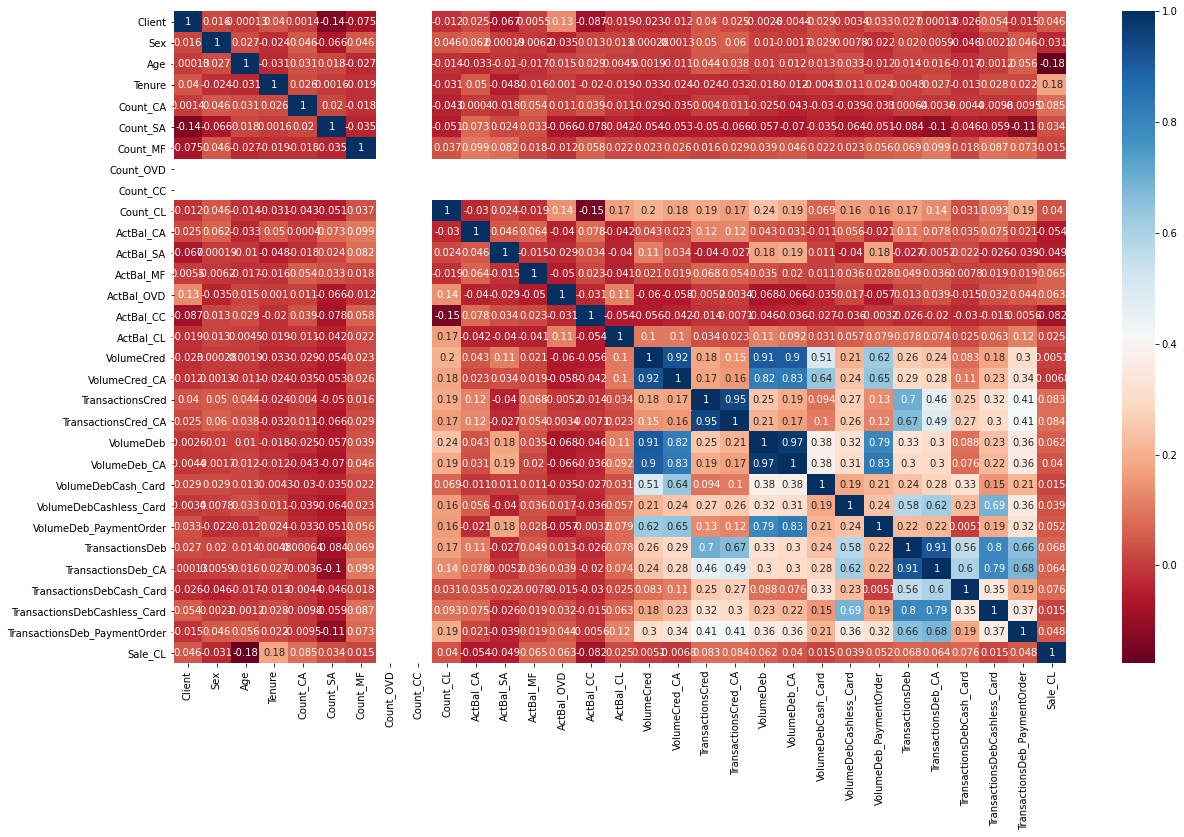

In [26]:
# Checking for multicollinearity

plt.figure(figsize=(20,12))
sns.heatmap(df_train.corr(),cmap='RdBu',annot=True);

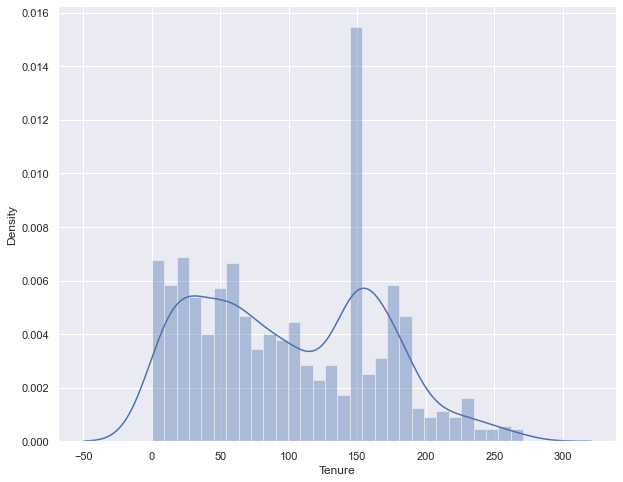

In [36]:
# density plot with tenure of customer with bank
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,8)})
sns.distplot(df_train.Tenure, bins=30);

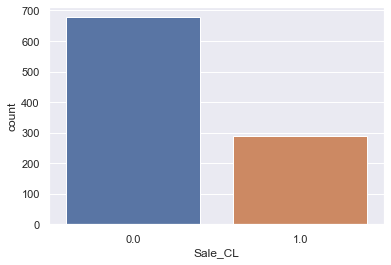

In [42]:
sns.set(rc={'figure.figsize':(6,4)})
sns.countplot(df_train.Sale_CL);

Their is clear imbalance in the data set we have to handle this also while applying our machine learning algorithm.
Two ways by which we can handle this class imbalance problem:    
1) By adjusting the class weight while training    
2) By over/under sampling of the data set    

In [64]:
#Splitting data set into train and test
# deviding the data set into target and predictors
X = df_train.copy()
X.drop(['Client','Sale_CL'],inplace = True, axis = 1)
y = df_train.iloc[:,30].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)


In [74]:
# def fit_models(scale = False):
#     results = []
#     minmax_scaler = MinMaxScaler()
#     scoring = [ 'precision', 'precision_macro', 
#                    'recall', 'recall_macro',
#                    'f1', 'f1_macro']
#     # Declaring parameters
#     R_STATE = 1
#     FOLDS = 5
#     OVER_SAMPLING_STRATEGY = 0.3
#     UNDER_SAMPLING_STRATEGY = 0.5
# #     Val_K = [str(i) for i in [7,9,15]]
# #     Val_K.append(math.sqrt(df_train.shape[0]))
#     lr_model = ('LR', LogisticRegression(class_weight={0:0.2,1:0.8},random_state= R_STATE))
#     rf_model = ('RF', RandomForestClassifier(class_weight={0:0.2,1:0.8},random_state=R_STATE))
#     xgb_model = ('XGB', XGBClassifier())
#     naive_bayes_model = ('NB',MultinomialNB())
#     # Declaring the models & other required lists
#     models, names, dfs = [], [], []
#     models.append(lr_model)
#     models.append(rf_model)
#     models.append(xgb_model)
#     models.append(naive_bayes_model)
#     for name, model in models:
#         # create the modeling pipeline
#         if scale ==True and name in ['LR','NB']:
#             Steps = [
#         #             ('i', KNNImputer(n_neighbors=31)),
#                     ('minmaxscaler',minmax_scaler),
#                     ('m', model)
#                 ]
#         else:
#             Steps = [
# #                     ('i', KNNImputer(n_neighbors=31)),
#                     ('m',model)
                
#             ]
#         pipeline = Pipeline(steps=Steps)
#         # evaluate the model
#         cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
#         scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
#         # store results
#         results.append(scores)
#         this_df = pd.DataFrame(results)
#         this_df['model'] = name
#         this_df
# #         dfs.append(this_df)
# #         dfs.head(3)
        
#     return this_df
        

##### Logistic Regression

In [110]:
scoring = [ 'precision', 'precision_macro', 
               'recall', 'recall_macro',
               'f1', 'f1_macro']
# Declaring parameters
R_STATE = 1
over = RandomOverSampler(sampling_strategy=0.3,random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
Steps = [
    #             ('i', KNNImputer(n_neighbors=31)),
#                 ('ov',over),
#                 ('un',under),
                ('minmaxscaler',MinMaxScaler(feature_range=(0, 1))),
                ('m', LogisticRegression(class_weight={0:0.2,1:0.8},random_state= R_STATE))
            ]
pipeline = Pipeline(steps=Steps)
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
# store results
this_df = pd.DataFrame(scores)
this_df['model'] = 'LR'
this_df

,fit_time,score_time,test_precision,test_precision_macro,test_recall,test_recall_macro,test_f1,test_f1_macro,model
0,0.057003,0.068004,0.307143,0.520238,0.914894,0.508373,0.459893,0.319377,LR
1,0.100006,0.078004,0.290323,0.483871,0.782609,0.487635,0.423529,0.361765,LR
2,0.091005,0.068004,0.320000,0.560000,0.869565,0.544874,0.467836,0.406580,LR
3,0.087005,0.105006,0.308824,0.543301,0.913043,0.521337,0.461538,0.341880,LR
4,0.098006,0.112006,0.316547,0.591607,0.956522,0.538446,0.475676,0.343529,LR
5,0.108006,0.057602,0.312977,0.531489,0.872340,0.519504,0.460674,0.366701,LR
6,0.088005,0.058801,0.302158,0.526079,0.913043,0.511568,0.454054,0.323027,LR
7,0.070603,0.062400,0.286765,0.459172,0.847826,0.478959,0.428571,0.308036,LR
8,0.078000,0.031200,0.298387,0.499194,0.804348,0.499396,0.435294,0.369821,LR
9,0.078000,0.031200,0.323741,0.628537,0.978261,0.553945,0.486486,0.357064,LR


In [117]:
# creating a parameter grid for cross validation and hyper parameter tuning

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid = {'m__max_iter':[30,40],
              'm__penalty':['l1','l2','elasticnet'],
              'm__class_weight':[{0:0.1,1:0.9},{0:0.20,1:0.80},'balanced']
#               'm__solver':['lbfgs','saga','liblinear']
              
}
# rf = LogisticRegression(random_state = 1)
grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = -1, verbose = 2)

In [118]:
# finding the best parameter from our cross validation
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 30 folds for each of 18 candidates, totalling 540 fits


{'m__class_weight': 'balanced', 'm__max_iter': 40, 'm__penalty': 'l2'}

In [119]:
# we are creating model out of the best grid generated by the cross validation
best_grid = grid_search.best_estimator_

In [120]:
# predicting the values using X_test data set
y_pred_lr = best_grid.predict(X_test)

In [121]:
confusion_matrix(y_test, y_pred_lr)

array([[101,  35],
       [ 23,  35]], dtype=int64)

In [122]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.81      0.74      0.78       136
         1.0       0.50      0.60      0.55        58

    accuracy                           0.70       194
   macro avg       0.66      0.67      0.66       194
weighted avg       0.72      0.70      0.71       194



##### Naive Bayes

In [96]:
scoring = [ 'precision', 'precision_macro', 
               'recall', 'recall_macro',
               'f1', 'f1_macro']
# Declaring parameters
R_STATE = 1
over = RandomOverSampler(sampling_strategy=0.3,random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
Steps = [
    #             ('i', KNNImputer(n_neighbors=31)),
#                 ('ov',over),
#                 ('un',under),
                ('minmaxscaler',MinMaxScaler(feature_range=(0, 1))),
                ('m', MultinomialNB())
            ]
pipeline = Pipeline(steps=Steps)
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
# store results
this_df = pd.DataFrame(scores)
this_df['model'] = 'NB'
this_df

,fit_time,score_time,test_precision,test_precision_macro,test_recall,test_recall_macro,test_f1,test_f1_macro,model
0,0.120007,0.068004,1.0,0.850649,0.021277,0.510638,0.041667,0.433047,NB
1,0.045002,0.098006,0.0,0.351613,0.000000,0.500000,0.000000,0.412879,NB
2,0.031002,0.102006,0.0,0.351613,0.000000,0.500000,0.000000,0.412879,NB
3,0.045002,0.083005,0.0,0.350649,0.000000,0.500000,0.000000,0.412214,NB
4,0.037002,0.062400,0.0,0.348684,0.000000,0.490741,0.000000,0.407692,NB
5,0.078000,0.062400,1.0,0.850649,0.021277,0.510638,0.041667,0.433047,NB
6,0.046800,0.062400,0.0,0.351613,0.000000,0.500000,0.000000,0.412879,NB
7,0.046800,0.078000,0.0,0.351613,0.000000,0.500000,0.000000,0.412879,NB
8,0.046800,0.046800,0.5,0.601974,0.021739,0.506240,0.041667,0.432372,NB
9,0.031200,0.031200,1.0,0.852941,0.021739,0.510870,0.042553,0.435070,NB


In [97]:
model = pipeline.fit(X_train,y_train)

In [98]:
y_pred = model.predict(X_test)

In [99]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.99      0.82       136
         1.0       0.33      0.02      0.03        58

    accuracy                           0.70       194
   macro avg       0.52      0.50      0.43       194
weighted avg       0.59      0.70      0.58       194



##### XGBoost Classifier

In [100]:
scoring = [ 'precision', 'precision_macro', 
               'recall', 'recall_macro',
               'f1', 'f1_macro']
# Declaring parameters
R_STATE = 1
over = RandomOverSampler(sampling_strategy=0.3,random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
Steps = [
    #             ('i', KNNImputer(n_neighbors=31)),
#                 ('ov',over),
#                 ('un',under),
                ('minmaxscaler',MinMaxScaler(feature_range=(0, 1))),
                ('m', XGBClassifier())
            ]
pipeline = Pipeline(steps=Steps)
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
# store results
this_df = pd.DataFrame(scores)
this_df['model'] = 'XGB'
this_df

,fit_time,score_time,test_precision,test_precision_macro,test_recall,test_recall_macro,test_f1,test_f1_macro,model
0,3.412436,0.078000,0.400000,0.562500,0.297872,0.551714,0.341463,0.552311,XGB
1,3.908641,0.164005,0.413793,0.571976,0.260870,0.552453,0.320000,0.551489,XGB
2,3.053636,0.078000,0.500000,0.620229,0.260870,0.575389,0.342857,0.575595,XGB
3,3.022436,0.109200,0.666667,0.723097,0.391304,0.653986,0.493151,0.667852,XGB
4,1.670440,0.062400,0.608696,0.682210,0.304348,0.610507,0.405797,0.617124,XGB
5,3.421868,0.062400,0.360000,0.533846,0.191489,0.521671,0.250000,0.511555,XGB
6,3.328268,0.078000,0.548387,0.657258,0.369565,0.620562,0.441558,0.628505,XGB
7,3.307658,0.078000,0.571429,0.677381,0.434783,0.648584,0.493827,0.657394,XGB
8,2.172628,0.078000,0.541667,0.643910,0.282609,0.590378,0.371429,0.593277,XGB
9,1.409813,0.065004,0.416667,0.569872,0.217391,0.543881,0.285714,0.537815,XGB


In [101]:
model = pipeline.fit(X_train,y_train)

[01:58:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [102]:
y_pred = model.predict(X_test)

In [103]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.89      0.80       136
         1.0       0.46      0.22      0.30        58

    accuracy                           0.69       194
   macro avg       0.60      0.56      0.55       194
weighted avg       0.65      0.69      0.65       194



In [75]:
fit_models(scale = True)

,fit_time,score_time,test_precision,test_precision_macro,test_recall,test_recall_macro,test_f1,test_f1_macro,model
0,"[0.049002647399902344, 0.08400487899780273, 0....","[0.06000328063964844, 0.05800342559814453, 0.0...","[0.30714285714285716, 0.2903225806451613, 0.32...","[0.5202380952380952, 0.4838709677419355, 0.56,...","[0.9148936170212766, 0.782608695652174, 0.8695...","[0.5083727344365642, 0.4876346230554448, 0.544...","[0.45989304812834225, 0.4235294117647059, 0.46...","[0.3193774183731142, 0.36176470588235293, 0.40...",NB
1,"[1.8132071495056152, 1.8288068771362305, 1.797...","[0.15600013732910156, 0.171600341796875, 0.171...","[0.4444444444444444, 0.6666666666666666, 0.5, ...","[0.5749619482496195, 0.6923937360178971, 0.607...","[0.0851063829787234, 0.08695652173913043, 0.08...","[0.5194050433412135, 0.5343039489429597, 0.525...","[0.14285714285714285, 0.15384615384615383, 0.1...","[0.4769403824521935, 0.4916517590936196, 0.484...",NB
2,"[3.2448055744171143, 3.354006052017212, 3.7440...","[0.04680013656616211, 0.062400102615356445, 0....","[0.4, 0.41379310344827586, 0.5, 0.666666666666...","[0.5625, 0.571975916803503, 0.6202290076335878...","[0.2978723404255319, 0.2608695652173913, 0.260...","[0.5517139479905437, 0.5524531312325489, 0.575...","[0.34146341463414637, 0.32, 0.3428571428571428...","[0.5523106546854943, 0.5514893617021277, 0.575...",NB
3,"[0.046799659729003906, 0.031199932098388672, 0...","[0.06240034103393555, 0.09360027313232422, 0.0...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.5, ...","[0.8506493506493507, 0.35161290322580646, 0.35...","[0.02127659574468085, 0.0, 0.0, 0.0, 0.0, 0.02...","[0.5106382978723404, 0.5, 0.5, 0.5, 0.49074074...","[0.04166666666666667, 0.0, 0.0, 0.0, 0.0, 0.04...","[0.4330470737913486, 0.4128787878787879, 0.412...",NB
